# Week 2 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "/Users/yslin624/Dropbox/Content Analysis/data/Movies" 
# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                print(file)
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
13.txt
text_16_qll.zip
16.txt
text_32_ldf.zip
32.txt
text_19_gvc.zip
19.txt
text_05_nko.zip
05.txt
text_17_arp.zip
17.txt
text_01_ote.zip
01.txt
text_28_rfy.zip
28.txt
text_31_akv.zip
31.txt
text_22_etp.zip
22.txt
text_11_uoy.zip
11.txt
text_09_oii.zip
09.txt
text_06_jfy.zip
06.txt
text_14_lnc.zip
14.txt
text_08_loh.zip
08.txt
text_33_kje.zip
33.txt
text_30_wkp.zip
30.txt
text_07_oma.zip
07.txt
text_03_mnq.zip
03.txt
text_21_fqa.zip
21.txt
text_29_oye.zip
29.txt
text_27_fle.zip
27.txt
text_23_fmh.zip
23.txt
text_12_rcq.zip
12.txt
text_00_myn.zip
00.txt
text_01_ote.zip
text_02_mqu.zip
text_03_mnq.zip
text_04_mlq.zip
text_05_nko.zip
text_06_jfy.zip
text_07_oma.zip
text_08_loh.zip
text_09_oii.zip
text_10_aoy.zip
text_11_uoy.zip
text_12_rcq.zip
text_13_idi.zip
text_14_lnc.zip
text_15_guo.zip
text_16_qll.zip
text_17_arp.zip
text_18_jfj.zip
text_19_gvc.zip
text_20_cde.zip
text_21_fqa.zip
text_22_etp.zip
text_23_fmh.zip
text_24_ywo.zip
text_25_byg.zip
text_26_ngj.zip
text_27_f

In [5]:
# This pick here is just one text file after unzipping
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
# These seems like very artificial cleaning, yet probably necessary.

def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
# The clean_text doesn't seem to work, are we cleaning everything with a '? or just those with a space in front?
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
print(clean_11[1])

@@216680 Hey , I'm talking to you Give me 600 dollars You wish ! That's all we've left And you still go to gamble Shut up I earn the money Even that you can't take it for gamble Shut up What're you doing ? Bastard , I'm gon na beat you You gambling pig , I'll beat the shit out of you You bitch I'll beat you You dare to hit me with something ! I'll kill you All you know is gambling I'll beat you What're you doing ? Let go of me Stop You'll kill Mom Mom , are you all right ? Don't touch my money Dad , where're you going ? Go away Dad , don't go Get lost Dad , come back You take Marble with you The way she's now Do you want to give me trouble ? I'm in more trouble than you I am a woman I'm a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don't marry a gambler Hey , you want a quarrel ? No , never This is the last ti

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,word,count
0,@@216680,1
1,hey,16
2,i,191
3,'m,24
4,talking,2
5,to,112
6,you,302
7,give,14
8,me,82
9,600,1


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
6,you,302
2,i,191
13,'s,126
5,to,112
31,it,109
...,...,...
248,postman,10
187,please,9
328,but,9
215,as,9


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

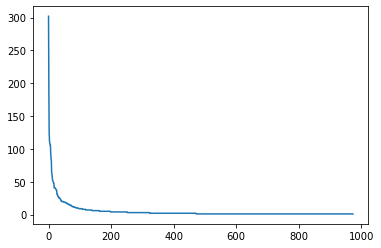

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

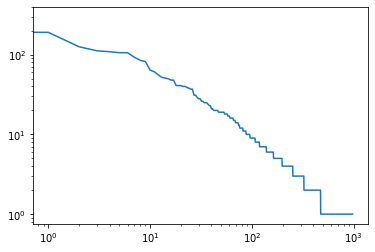

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [19]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [20]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [21]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [22]:
import nltk

In [23]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('stem')

Displaying 7 of 7 matches:
ay April 10 2007 illustrated the hope stem cell research can offer in a speech o
slation to expand federal funding for stem cell research Whitehouse met Lila two
nce transplants with a patient 's own stem cells which could replace the lost bo
gressman Jim Langevin D a champion of stem cell legislation nationally and in Rh
 today released a statewide report on stem cells a first step toward developing 
expands the number of human embryonic stem cells eligible for federally funded r
n Services HHS to conduct research on stem cells derived from embryos currently 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

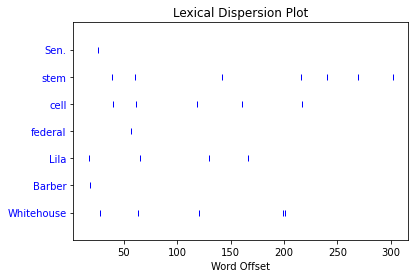

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [27]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,name,text,path,html_url,download_url
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

For now, my idea on the final project is to use data from right/left wing media to check whether they adhere to Trump's rhetoric. In this part, I am just trying to get a broad understanding of what news corpus looks like. 

In [31]:
# Try to get the ones about news on different media
# Ideally I want data after 2016, yet I haven't download the NOW corpora yet, so I'l use COCA first.
main_corpus = '/Users/yslin624/Dropbox/Content Analysis/data/COCA'
coca_raw = loadcorpus(main_corpus)

text_magazine_jex.zip
w_mag_1990.txt
w_mag_1991.txt
w_mag_1992.txt
w_mag_1993.txt
w_mag_1994.txt
w_mag_1995.txt
w_mag_1997.txt
w_mag_1998.txt
w_mag_1999.txt
w_mag_2000.txt
w_mag_2001.txt
w_mag_2002.txt
w_mag_2003.txt
w_mag_2004.txt
w_mag_2005.txt
w_mag_2006.txt
w_mag_2007.txt
w_mag_2008.txt
w_mag_2009.txt
w_mag_2010.txt
w_mag_2011.txt
w_mag_2012.txt
w_mag_1996.txt
text_spoken_kde.zip
w_spok_1990.txt
w_spok_1991.txt
w_spok_1992.txt
w_spok_1993.txt
w_spok_1994.txt
w_spok_1995.txt
w_spok_1996.txt
w_spok_1997.txt
w_spok_1998.txt
w_spok_1999.txt
w_spok_2000.txt
w_spok_2001.txt
w_spok_2002.txt
w_spok_2003.txt
w_spok_2004.txt
w_spok_2005.txt
w_spok_2006.txt
w_spok_2007.txt
w_spok_2008.txt
w_spok_2009.txt
w_spok_2010.txt
w_spok_2011.txt
w_spok_2012.txt
text_fiction_awq.zip
w_fic_1990.txt
w_fic_1991.txt
w_fic_1992.txt
w_fic_1993.txt
w_fic_1994.txt
w_fic_1995.txt
w_fic_1996.txt
w_fic_1997.txt
w_fic_1998.txt
w_fic_1999.txt
w_fic_2000.txt
w_fic_2001.txt
w_fic_2002.txt
w_fic_2003.txt
w_fic_2004.txt

In [32]:
# Add some cleaning for this text, because of the different formatting.
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_text = clean_text.replace("<p> ", "")
            clean_texts.append(clean_text)
        except AttributeError:
            print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            print("Unicode Error, Skip")
            continue
    return clean_texts

clean_2015 = clean_raw_text(coca_raw['2015_news.txt'])


In [33]:
count_words = wordCounter(word_tokenize(clean_2015[1]))
count_words.sort_values('count', ascending = False, inplace = True)

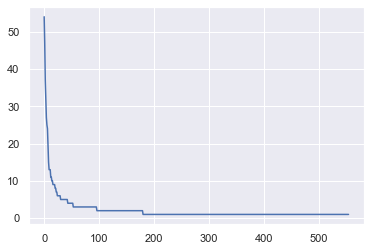

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_words)), count_words['count'])
plt.show()

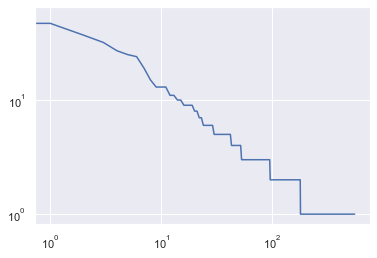

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(count_words)), count_words['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Though not as fitting as the Movie dataset, we can still get some approximation of Zipf's Law

In [36]:
# Change a document to see how things are
newstoken = word_tokenize(clean_2015[3])
news_text = nltk.Text(newstoken)
wordCounter(newstoken).sort_values(by = 'count', ascending = False)[:30]

,word,count
18,the,94
63,in,56
17,to,50
43,he,50
20,of,50
2,a,44
25,and,38
5,his,37
13,mcdonnell,31
99,for,27


In [37]:
# This is just a simple check of the main character in this news post after using word count.
# It seems like this post is related to a court case, and the word count cannot filter out the main theme of this case.
newsindex = nltk.text.ConcordanceIndex(news_text)
newsindex.print_concordance('McDonnell')

Displaying 25 of 31 matches:
former Virginia governor Robert F. McDonnell paid a quiet visit to the home of 
e home of an old Alexandria friend McDonnell and Liz Reiley had seen each other
enforced limbo that have separated McDonnell 's shocking guilty verdict from hi
 It has been an emotional time for McDonnell who potentially faces a sentence o
ghter Jeanine who is pregnant with McDonnell 's first grandchild due this month
d has been blamed by many close to McDonnell for creating the scandal After 38 
urban Richmond Alongside his grief McDonnell appears to have also spent the pas
 be allowed to remain free on bail McDonnell 's attorneys have asked that he be
e for that said Joe Damico a close McDonnell friend from high school This is a 
f a decade or more would mean that McDonnell life behind bars He would probably
tional grand- children Damico said McDonnell 's message to his children however
as told them The worst moments for McDonnell friends said were the 24 hours rig
s right aft

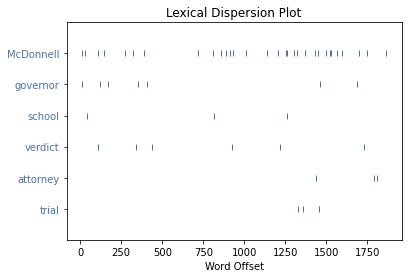

In [38]:
# Check on some of the words that appeared above to get a sense of how the reporting timeline was done

sns.reset_orig() #Seaborn messes with this plot, disabling it
news_text.dispersion_plot(['McDonnell','governor', 'school', 'verdict' ,'attorney', 'trial'])
sns.set() #Re-enabling seaborn

# This aligns with common sense, as for a court case, the news would probably talk about the main character over and over
# and things related to the result (verdict) would be mentioned quited early.
# More detailed facts that relates to attorney general and trial would be written in the last part.

#### It would probably be better to do a snowball sampling if I want to get a sense of how news media adhere to Trump's rhetoric. Selecting random news article from this corpus probably won't help much on my final project.


# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [39]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [40]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [41]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [42]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,name,text,path,html_url,download_url,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,raw/Whitehouse/10Apr2007Whitehouse123.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,raw/Whitehouse/10Apr2008Whitehouse2.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,raw/Whitehouse/10Apr2008Whitehouse3.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,raw/Whitehouse/10Aug2007Whitehouse78.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,raw/Whitehouse/10Jan2008Whitehouse35.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...",raw/Whitehouse/10Mar2008Whitehouse8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sen, reed, whitehouse, welcome, rhode, island...",197
6,10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,raw/Whitehouse/10Sep2007Whitehouse72.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,raw/Whitehouse/11Apr2007Whitehouse122.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...",raw/Whitehouse/11Jan2007Whitehouse161.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sen, reed, whitehouse, urge, portugal, recons...",237
9,11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,raw/Whitehouse/11Mar2008Whitehouse7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveils, bush, debt, $, foregone,...",241


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [43]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

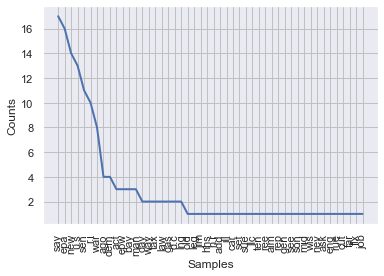

In [44]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [45]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [46]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [47]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [48]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 125, 'NNP': 41})),
 ('whitehouse', FreqDist({'NN': 19, 'NNP': 12, 'VB': 8, 'VBP': 1})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'NNP': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [49]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [50]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [51]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 19),
 ('today', 15),
 ('stem', 12),
 ('year', 12),
 ('administration', 11)]

Or plot the base form verbs against their number of occurrences

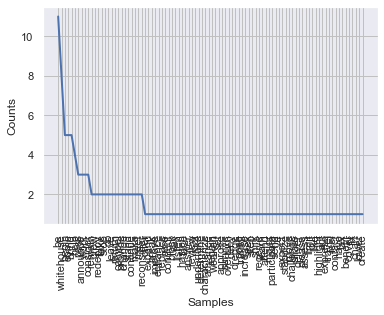

In [52]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [53]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025390625


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

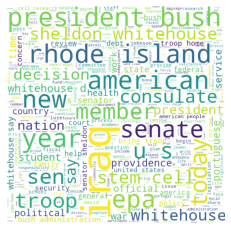

In [54]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

#### Again, my objective is related to specifically 2016-2020. In this exercise I will only focus on trying to uncover some characteristics in the year 2015, with no specific sampling techniques used, further project related exercise will wait until I can get a desired corpora.

In [55]:
# First step is to get all the files in 2015_news corpus.
# There's 2880 different files, it would be better to pick maybe 200 for this homework to save processing time.
news_2015 = pandas.DataFrame({'text': clean_raw_text(coca_raw['2015_news.txt'][:200])})
news_2015['tokenized_text'] = news_2015['text'].apply(lambda x: word_tokenize(x))

In [56]:
newsDict = {}
for word in news_2015['tokenized_text'].sum():
    if word in newsDict:
        newsDict[word] += 1
    else:
        newsDict[word] = 1
word_counts = sorted(newsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]

[('the', 12992),
 ('to', 7012),
 ('a', 6788),
 ('and', 6562),
 ('of', 6393),
 ('in', 4902),
 ("'s", 3142),
 ('that', 3109),
 ('for', 2372),
 ('is', 2206),
 ('was', 2200),
 ('with', 1891),
 ('on', 1865),
 ('said', 1829),
 ('he', 1674),
 ('The', 1523),
 ('it', 1505),
 ('as', 1459),
 ('his', 1366),
 ('at', 1328),
 ('I', 1217),
 ('has', 1177),
 ('from', 1140),
 ('have', 1120),
 ('by', 1085),
 ('are', 1081),
 ('who', 1008),
 ('an', 1003),
 ('be', 1002),
 ('they', 915),
 ('not', 871),
 ("n't", 787),
 ('had', 715),
 ('their', 708),
 ('about', 706),
 ('or', 689),
 ('this', 689),
 ('more', 671),
 ('but', 604),
 ('were', 602),
 ('will', 600),
 ('one', 593),
 ('He', 591),
 ('would', 575),
 ('we', 570),
 ('But', 568),
 ('$', 561),
 ('It', 555),
 ('her', 543),
 ('she', 537),
 ('you', 533),
 ('do', 523),
 ('out', 516),
 ('2', 515),
 ('been', 514),
 ('up', 506),
 ('A', 489),
 ('which', 471),
 ('all', 468),
 ('In', 464),
 ('than', 450),
 ('people', 449),
 ('when', 445),
 ('leftnull', 428),
 ('what', 4

In [57]:
# By observation, the first stop word would probably be "Obama"
# There are of course gender related words that might come to interest in social science
# Yet for now let's just set the stop word as Obama and carry on with the exercise

stop_words_freq = []
for word, count in word_counts:
    if word == 'Obama':
        break
    else:
        stop_words_freq.append(word)

In [58]:
news_2015['normalized_tokens'] = news_2015['tokenized_text'].apply(lambda x: normalizeTokens(x))

news_2015['normalized_tokens_count'] = news_2015['normalized_tokens'].apply(lambda x: len(x))

news_2015

,text,tokenized_text,normalized_tokens,normalized_tokens_count
0,@@4132198 It's always nice to start a year by ...,"[@@4132198, It, 's, always, nice, to, start, a...","[@@4132198, nice, start, year, right, number, ...",604
1,@@4132199 Six years after candidate Barack Oba...,"[@@4132199, Six, years, after, candidate, Bara...","[@@4132199, year, candidate, barack, obama, vo...",659
2,@@4132200 The latest thing at ' Downton Abbey ...,"[@@4132200, The, latest, thing, at, Downton, A...","[@@4132200, late, thing, downton, abbey, exit,...",516
3,@@4132201 About a month after his corruption c...,"[@@4132201, About, a, month, after, his, corru...","[@@4132201, month, corruption, conviction, vir...",904
4,@@4132202 A spa official handed us each a burl...,"[@@4132202, A, spa, official, handed, us, each...","[@@4132202, spa, official, hand, burlap, bag, ...",646
...,...,...,...,...
195,@@4132444 Thousands of public U.S. companies a...,"[@@4132444, Thousands, of, public, U.S., compa...","[@@4132444, thousand, public, u.s, company, li...",667
196,"@@4132445 MANCHESTER , N.H. - It seemed clear ...","[@@4132445, MANCHESTER, N.H., It, seemed, clea...","[@@4132445, manchester, n.h, clear, week, repu...",660
197,@@4132446 RICHMOND - With cornerback Chris Cul...,"[@@4132446, RICHMOND, With, cornerback, Chris,...","[@@4132446, richmond, cornerback, chris, culli...",496
198,"@@4132447 On paper , Allegiant Air has never l...","[@@4132447, On, paper, Allegiant, Air, has, ne...","[@@4132447, paper, allegiant, air, look, well,...",519


In [59]:
# This is to simply categorize words by their length.
newscfdist = nltk.ConditionalFreqDist(((len(w), w) for w in news_2015['normalized_tokens'].sum()))


<ConditionalFreqDist with 24 conditions>

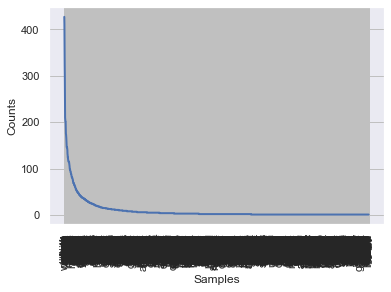

In [60]:
# Due to the large size of the chosen corpora, we probably need to do some winsorizing before producing a plot
# But without really looking into the detail, it seems that the distribution fits Zipf's law quite well.
newscfdist[5].plot()

In [61]:
news_2015['normalized_tokens_POS'] = [spacy_pos(t) for t in news_2015['text']]

In [62]:
newscfdist_WordtoPOS = nltk.ConditionalFreqDist(news_2015['normalized_tokens_POS'].sum())
list(newscfdist_WordtoPOS.items())[:10]

[('@@4132198', FreqDist({'NFP': 1})),
 ('it', FreqDist({'PRP': 2061})),
 ("'s", FreqDist({'POS': 2199, 'VBZ': 914, 'PRP': 28, 'NN': 1})),
 ('always', FreqDist({'RB': 77})),
 ('nice', FreqDist({'JJ': 13})),
 ('to', FreqDist({'TO': 4476, 'IN': 2603})),
 ('start', FreqDist({'VB': 34, 'NN': 32, 'VBP': 12})),
 ('a', FreqDist({'DT': 7275, 'RB': 1, 'FW': 1})),
 ('year', FreqDist({'NN': 337, 'JJ': 1})),
 ('by', FreqDist({'IN': 1149, 'RB': 6, 'RP': 5, 'NN': 1}))]

In [63]:
newscfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in news_2015['normalized_tokens_POS'].sum())

In [64]:
# Let's start with the most popular nouns.
newscfdist_POStoWord['NN'].most_common(10)

# It is quite natural to have time, state, year, government which is typical newspaper stuff
# However, it is less clear which noun "block" means here, which is probably worth investigating 

[('time', 414),
 ('block', 391),
 ('year', 337),
 ('state', 267),
 ('@', 234),
 ('government', 227),
 ('way', 218),
 ('day', 213),
 ('school', 183),
 ('life', 182)]

In [65]:
# The case for proper noun is quite interesting
newscfdist_POStoWord['NNP'].most_common(20)

# One interesting thing to notice is that the first country that shows up in NNP case is Iran, which makes sense
# as the Nuclear deal was signed in 2015.
# Clinton also showed up, as she declared to run for president in early 2015, 
# Meanwhile, Trump is still nowhere in sight 

[('.', 2153),
 ('st', 382),
 ('obama', 335),
 ('p.m', 328),
 ('washington', 289),
 ('u.s', 210),
 ('leftnull', 203),
 ('united', 188),
 ('clinton', 183),
 ('house', 182),
 ('iran', 175),
 ('jan', 147),
 ('president', 144),
 ('states', 144),
 ('new', 139),
 ('s.', 133),
 ('white', 131),
 ('rd', 126),
 ('national', 118),
 ('a.m', 113)]

In [66]:
newscfdist_POStoWord['PRP'].most_common(20)

# I want to investigate pronouns as to see how gender may differ in news reporting.
# Taking the correctness of this classification as given, it seems that male pronouns are more heavily used than female
# Why this is the case is not exactly clear to me, might be due to the type of corpus we have, or inherent bias
# any of which explanations are a bit too early to draw a conclusion.

[('he', 2265),
 ('it', 2061),
 ('i', 1215),
 ('they', 1139),
 ('we', 841),
 ('she', 745),
 ('you', 657),
 ('him', 371),
 ('them', 327),
 ('me', 186),
 ('us', 137),
 ('her', 115),
 ('himself', 63),
 ('themselves', 52),
 ('itself', 36),
 ("'s", 28),
 ('herself', 17),
 ('yourself', 16),
 ('myself', 15),
 ('one', 13)]

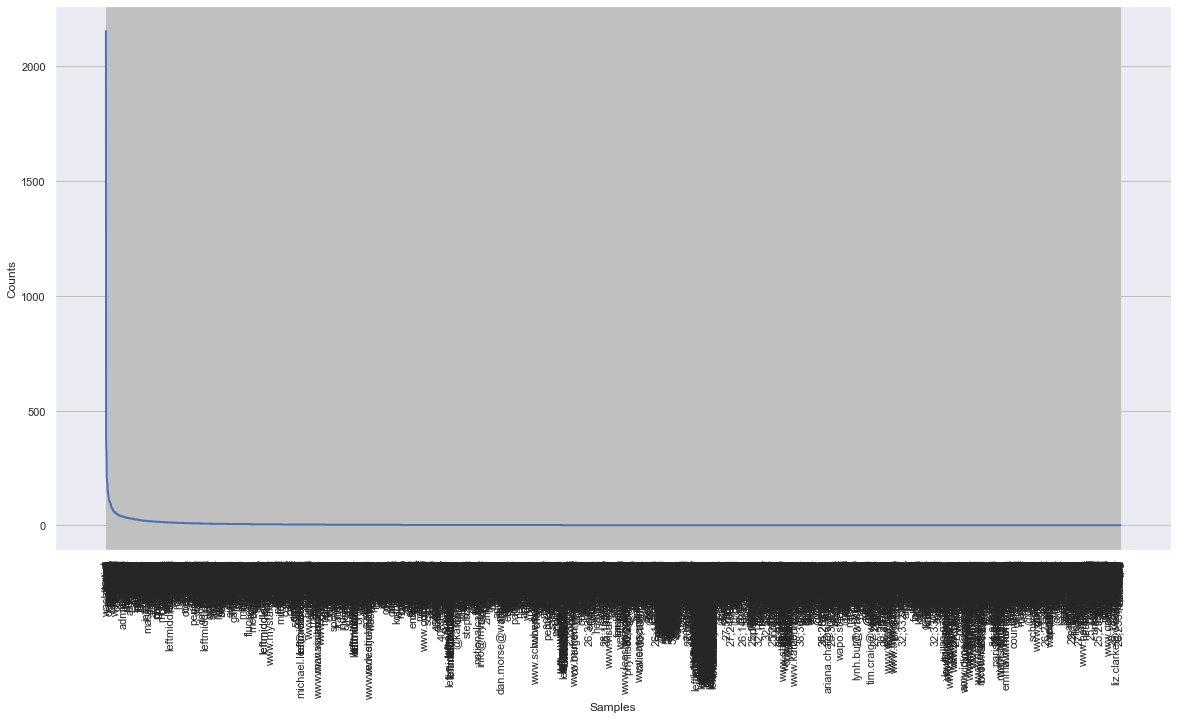

In [67]:
# Again we should probably winsorize this file a bit
# Will do that if we need further investigation into the words.
plt.figure(figsize = (20,10))
newscfdist_POStoWord['NNP'].plot()

#### Notice I didn't include the probability calculation here. The reason is that I cannot find any interesting thing after investigation.

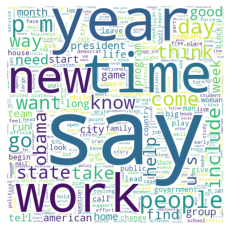

In [68]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(news_2015['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("new_2015_wordcloud.pdf", format = 'pdf')



## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [69]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [70]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [71]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [136]:
movie_texts = {}
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [137]:
import pandas as pd

In [138]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [139]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
6850720,Animal Crackers,"Comedy, Musical",1930,English,"[You, must, do, your, best, tonight, Be, on, y..."
176501,Anna Christie,"Drama, Romance",1930,English,"[Either, you, 're, flat, or, I, am, I, beg, yo..."
4056770,Ladies of Leisure,"Drama, Romance",1930,English,"[Look, out, There, 's, another, bottle, coming..."
5992934,Over the Hill,Drama,1931,English,"[Good, morning, kitty, Come, in, here, baby, I..."
4436137,Design for Living,"Comedy, Romance",1933,"English, French","[Train_engine_grinding, 26;1426;TOOLONG, Whist..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [73]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [74]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [75]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [76]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [77]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me, Hello, IT], [>], [$, Usr, Hi, I,..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [78]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [79]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [80]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, RB), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NNP), (1](http://www.reddit.com, NNP)...
1    [[(>, XX)], [($, $), (Me, PRP), (Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [81]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('time', 14),
 ('Usr', 14),
 ('m', 13),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [82]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [83]:
news_2015['sentences'] = news_2015['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
news_2015.index = range(len(news_2015) - 1, -1,-1) #Reindex to make things nice in the future
news_2015

,text,tokenized_text,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences
199,@@4132198 It's always nice to start a year by ...,"[@@4132198, It, 's, always, nice, to, start, a...","[@@4132198, nice, start, year, right, number, ...",604,"[(@@4132198, NFP), (it, PRP), ('s, VBZ), (alwa...","[[@@4132198], [It, 's, always, nice, to, start..."
198,@@4132199 Six years after candidate Barack Oba...,"[@@4132199, Six, years, after, candidate, Bara...","[@@4132199, year, candidate, barack, obama, vo...",659,"[(@@4132199, NFP), (six, CD), (years, NNS), (a...","[[@@4132199], [Six, years, after, candidate, B..."
197,@@4132200 The latest thing at ' Downton Abbey ...,"[@@4132200, The, latest, thing, at, Downton, A...","[@@4132200, late, thing, downton, abbey, exit,...",516,"[(@@4132200, NFP), (the, DT), (latest, JJS), (...","[[@@4132200], [The, latest, thing, at, Downton..."
196,@@4132201 About a month after his corruption c...,"[@@4132201, About, a, month, after, his, corru...","[@@4132201, month, corruption, conviction, vir...",904,"[(@@4132201, NFP), (about, IN), (a, DT), (mont...","[[@@4132201, About, a, month, after, his, corr..."
195,@@4132202 A spa official handed us each a burl...,"[@@4132202, A, spa, official, handed, us, each...","[@@4132202, spa, official, hand, burlap, bag, ...",646,"[(@@4132202, NFP), (a, DT), (spa, NN), (offici...","[[@@4132202], [A, spa, official, handed, us, e..."
...,...,...,...,...,...,...
4,@@4132444 Thousands of public U.S. companies a...,"[@@4132444, Thousands, of, public, U.S., compa...","[@@4132444, thousand, public, u.s, company, li...",667,"[(@@4132444, NFP), (thousands, NNS), (of, IN),...","[[@@4132444, Thousands, of, public, U.S., comp..."
3,"@@4132445 MANCHESTER , N.H. - It seemed clear ...","[@@4132445, MANCHESTER, N.H., It, seemed, clea...","[@@4132445, manchester, n.h, clear, week, repu...",660,"[(@@4132445, NFP), (manchester, NNP), (,, ,), ...","[[@@4132445], [MANCHESTER], [N.H.], [It, seeme..."
2,@@4132446 RICHMOND - With cornerback Chris Cul...,"[@@4132446, RICHMOND, With, cornerback, Chris,...","[@@4132446, richmond, cornerback, chris, culli...",496,"[(@@4132446, NNP), (richmond, NNP), (-, :), (w...","[[@@4132446, RICHMOND, With, cornerback, Chris..."
1,"@@4132447 On paper , Allegiant Air has never l...","[@@4132447, On, paper, Allegiant, Air, has, ne...","[@@4132447, paper, allegiant, air, look, well,...",519,"[(@@4132447, NFP), (on, IN), (paper, NN), (,, ...","[[@@4132447], [On, paper, Allegiant, Air, has,..."


In [84]:
news_2015['POS_sents'] = news_2015['sentences'].apply(lambda x: tag_sents_pos(x))

In [85]:
news_2015['POS_sents']

199    [[(@@4132198, NFP)], [(It, PRP), ('s, VBZ), (a...
198    [[(@@4132199, NFP)], [(Six, CD), (years, NNS),...
197    [[(@@4132200, NFP)], [(The, DT), (latest, JJS)...
196    [[(@@4132201, NFP), (About, RB), (a, DT), (mon...
195    [[(@@4132202, NNP)], [(A, DT), (spa, NN), (off...
                             ...                        
4      [[(@@4132444, NFP), (Thousands, NNS), (of, IN)...
3      [[(@@4132445, NFP)], [(MANCHESTER, NNP), (N.H....
2      [[(@@4132446, NFP)], [(RICHMOND, NNP), (With, ...
1      [[(@@4132447, NFP), (On, IN), (paper, NN), (Al...
0      [[(@@4132448, NFP)], [(RAFAH, NN), (GAZA, NN),...
Name: POS_sents, Length: 200, dtype: object

In [86]:
countTarget = 'NN'
targetCounts = {}
for entry in news_2015['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:30]

[('time', 410),
 ('block', 378),
 ('year', 336),
 ('government', 218),
 ('way', 214),
 ('day', 196),
 ('president', 180),
 ('school', 178),
 ('state', 177),
 ('program', 174),
 ('life', 172),
 ('percent', 168),
 ('part', 167),
 ('week', 167),
 ('team', 155),
 ('leftnull', 154),
 ('group', 151),
 ('city', 145),
 ('campaign', 144),
 ('work', 143),
 ('country', 140),
 ('world', 134),
 ('lot', 134),
 ('family', 131),
 ('company', 131),
 ('home', 129),
 ('something', 129),
 ('deal', 126),
 ('game', 114),
 ('business', 111)]

In [87]:
NTarget = 'JJ'
Word = 'block'
NResults = set()
for entry in news_2015['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)   


{'low', 'unremarkable'}


In [88]:
NTarget = 'JJ'
Word = 'business'
NResults = set()
for entry in news_2015['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'Big', 'eclectic', 'municipal', 'official', 'wholesale', 'daily', 'new', 'big', 'efficient', 'coherent', 'outside', 'anti'}


#### The mystery in the last 2 exercise is, why is block on such a high rank in nouns used, this result shows that block might be used as a more intangible noun rather than a real block, either it means street or concrete or gold. It is not clear what unremarkable means, but low block would probably be associated with American football, which in the next stage we should be turning it into a 2-gram.
#### Also, we can look into adjectives associated with business to see a broad view of how people view business. It is quite cool that "big" and "anti" are on the list (I suspect frequency wise it also they are on the top of the list), suggesting there might exist some concerns for big-tech luring in 2015.

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [89]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [90]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [91]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24
The first word is:  24, The second word is: 13


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [92]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('senator', 'sheldon'), 49.710393897443225),
 (('jack', 'reed'), 48.00268738075493),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('u.s', 'senator'), 37.28800351091628),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.08678784585

There are a few other available measures

In [93]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [94]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.4489309184218513),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.2358690250393414),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319915352945694),
 (('jack', 'reed', 'd'), 1.7319795610977395),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.7312605105781043),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('senators', 'jack', 'reed'), 1.4142032966377853),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement

Or n-grams (for any number n)

In [95]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [96]:
import gensim

In [97]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [98]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [99]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [100]:
newsBigrams = nltk.collocations.BigramCollocationFinder.from_words(news_2015['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(newsBigrams.N))

There are 142367 bigrams in the finder


In [101]:
# This result are mostly easy to see why, probably "e", "mail" should be counted as e-mail a single word.
# Interestingly again, block comes up a lot, it is however not clear what s. block and n. block means
# Another thing is that theft report is number 3 on the list, it is not clear whether this means that safety is at risk
# or news fundamentally like to report these kinds of reports.
print(newsBigrams.nbest(bigramScoring, 10))

[('united', 'states'), ('e', 'mail'), ('theft', 'report'), ('white', 'house'), ('s.', 'block'), ('n.', 'block'), ('new', 'york'), ('p.m', 'jan'), ('st', 's.'), ('year', 'ago')]


In [102]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
newsBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('e', 'mail'), 1984.6801614073852),
 (('united', 'states'), 1937.792267544604),
 (('theft', 'report'), 1434.6991567588987),
 (('white', 'house'), 1208.586752156157),
 (('n.', 'block'), 1154.3135134220768),
 (('s.', 'block'), 1081.9133612598816),
 (('new', 'york'), 1026.346154677565),
 (('p.m', 'jan'), 882.9056349492698),
 (('st', 's.'), 812.6205026080004),
 (('st', 'n.'), 684.8162075196295),
 (('year', 'ago'), 635.2843194391693),
 (('prime', 'minister'), 629.7041121516964),
 (('assault', 'report'), 547.8883426284449),
 (('saudi', 'arabia'), 531.1783903874729),
 (('los', 'angeles'), 516.7925178579857),
 (('mr', 'sifford'), 472.9622907126477),
 (('property', 'damage'), 432.8299017627148),
 (('islamic', 'state'), 430.0054383337417),
 (('a.m', 'jan'), 428.5460040108754),
 (('homer', 'rbi'), 414.88065096932337)]

In [103]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(news_2015['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('st', 's.', 'block'), 8.717674788562698),
 (('st', 'n.', 'block'), 8.30651701252561),
 (('block', 'theft', 'report'), 6.85551152227262),
 (('jan', 'theft', 'report'), 5.567703712831814),
 (('block', 'assault', 'report'), 5.196037585687306),
 (('n.', 'block', 'theft'), 4.898922720974671),
 (('s.', 'block', 'theft'), 4.795761413601716),
 (('e', 'mail', 'account'), 4.582560068022296),
 (('duke', 'st', 'block'), 4.582521111625722),
 (('s.', 'block', 'property'), 4.472087085211724),
 (('hillary', 'rodham', 'clinton'), 4.3588974415668496),
 (('washington', 'national', 'cathedral'), 4.358872250838922),
 (('p.m', 'jan', 'theft'), 4.358833253578593),
 (('wisconsin', 'ave', 'nw'), 4.242638200358409),
 (('block', 'property', 'damage'), 4.2426182226816245),
 (('king', 'st', 'block'), 4.122999949395058),
 (('n.', 'block', 'property'), 3.9999548106073464),
 (('s.', 'block', 'assault'), 3.9999488643574272),
 (('speak', 'condition', 'anonymity'), 3.8729821575048478),
 (('shoplifting', 'incident', '

#### We can probably guess that block is related to the reporting of social news. s. block, n. block, st associated with them, and also "theft" that appears a lot means that reporters are probably describing the geographical location of incidents.
#### Another cool thing, people actually do write out Hillary Clinton's full name when they are reporting...

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [104]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [105]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [106]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [107]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [108]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [109]:
redditTopScores['classified_sents']

9    [[(Last year, DATE)], [(one, CARDINAL)], [], [...
8    [[(First, ORDINAL)], [], [], [(today, DATE)], ...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [], [(30,000, CARDINAL), ...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [(Engineer, PERSON)], [(All good, TIME)],...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [(4, CARDINAL)], [], [], [], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[(normal day, DATE)], [], [], [(recently past...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [110]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Smith', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('4', 4),
 ('two', 4),
 ('9', 3),
 ('second', 3)]

Or those occurring only twice:

In [111]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'each day',
 '30k',
 'hours',
 'last week',
 'three',
 'Usr',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [112]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Smith', 6),
 ('Google Bing', 5),
 ('4', 4),
 ('two', 4),
 ('Boss', 4),
 ('9', 3),
 ('second', 3)]

What about the Organizations?

In [113]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Computer C O M P U T E
CAPITAL P. NUMBER FOUR
X'mas
6 Needless
picture](http://imgur.com
Email
REAL
POS
COM
CMD
UGHHHHH
Edit
Bing Search
Google Chrome
Caller
Boss Wife 's
Boss
USB
Boss 's Wife
Edit 2
TodaysDate
Proceed
Usr


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [114]:
news_2015['classified_sents'] = news_2015['sentences'].apply(lambda x: tag_sents_ner(x))
news_2015['classified_sents']

199    [[], [(a year, DATE)], [(2015, DATE), (U.S., G...
198    [[], [(Six years, DATE), (Barack Obama, PERSON...
197    [[], [(Downton Abbey Exit, ORG)], [(Downton Ab...
196    [[(About a month, DATE), (Virginia, GPE), (Rob...
195    [[], [], [(Bulhanzungmok, GPE)], [(Korean, NOR...
                             ...                        
4      [[(Thousands, CARDINAL), (U.S., GPE)], [(The S...
3      [[], [], [(this week, DATE), (Republican, NORP...
2      [[], [(Chris Culliver, PERSON), (Day 5, DATE),...
1      [[(Its second quarter, DATE), (more than 60 pe...
0      [[], [], [(Israeli, NORP), (Hamas, ORG)], [(tw...
Name: classified_sents, Length: 200, dtype: object

In [115]:
entityCounts = {}
for entry in news_2015['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('2', 350),
 ('first', 317),
 ('one', 301),
 ('two', 243),
 ('Obama', 224),
 ('U.S.', 179),
 ('Iran', 165),
 ('Washington', 137),
 ('American', 132),
 ('three', 118)]

In [116]:
GpeCounts = {}
for entry in news_2015['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                print(ent)

U.S.
U.S.
U.S.
U.S.
Reserve
Bethesda
China
Ghana
Washington
Pathways
Ghana
Nashville
Britain
Downton
Imagine
Downton
Downton
Downton
England
Downton
Downton
Boston
Downton
Downton
Virginia
Alexandria
Virginia Beach
Richmond
Richmond
Virginia Beach
Virginia Beach
Richmond
Virginia Beach
America
Virginia
Virginia Beach
Alexandria
Richmond
Virginia Beach
Henrico County
Henrico
Virginia Beach
Cailin
Richmond
Richmond
Florida
Virginia
Bulhanzungmok
the United States
Korea
Korea
Korea
Bulhanzungmok
Korea
Ridgefield
Barbecue
Shelby County
Alabama
Texas
Florida
the United States
Gary Ind.
Trayvon Martin
the United States
America
Austin
Keen
U.S.
Airbnb
Instagram
the United Kingdom
Advances
New York
Chicago
Louisiana
New York
Washington
Washington
the United States
U.S.
Ohio
California
New Republic
Russia
Moscow
U.S.
Russia
Ukraine
Russia
Ukraine
Washington
the United States Dudley
U.S.
Moscow
Mississippi
London
Russia
Ukraine
Ukraine
the United States
E.U.
Russia
Russia
BP
Russia
New Orleans
G

Washington
Manhattan
Jafri
U.S.
the United States
Jafri
America
Jafri
Washington
the District of Columbia
Paradise Village
Lagos
Festac
Festac
Festac
Nigeria
Festac
Nigeria
Woodstock
Nigeria
Nigeria
Festac
Lagos
Udoh
Gloria
Festac
Gloria
Nigeria
Mamuka Tsereteli
Daikaya
Georgia
Washington
Daikaya
Manhattan
khachapuri
Washington
Washington
khachapuri
Russia
Georgia
Washington
Russia
Georgia
Washington
District
Georgia
Georgia
Georgia
West Virginia
Georgia
Georgia
Georgia
Georgia
Brockett
Georgia
Alexandria
U.S.
U.S.
Philadelphia
U.S.
Mexico
U.S.
the United States
the United States
Washington
Manassas Va.
the United States
Soulen
America
District
Fairfax County Va.
Utah
Mountain View
Calif.
Blucora
Sophos
Somalia
U.S.
the United States
Yemen
Somalia
Yemen
Yemen
Somalia
Kenya
Somalia
Kenya
Somalia
Kenya
African Union
Somalia
The United States
Yemen
Afghanistan
Somalia
Afghanistan
Somalia
United States
U.S.
U.S.
U.S.
Somalia
Somalia
U.S.
U.S.
Iran
Tennessee
Pakistan
Bandar
Afghanistan
Kabu

Las Vegas Orlando
Virginia
Maryland
Oregon
Washington
New Jersey 's
Israel
the United States
Zimbabwe
South Africa
Sweden
Brazil
Yanomami
Zaraska
France
Manhattan
New York
San Francisco
Toronto
D.C.
New York 's
Boston
Toronto
New York
Boston
San Francisco
Washington
New York City
Manhattan
New York
San Francisco
San Francisco 's
San Francisco
San Francisco
Mexico City
San Francisco
Washington
Washington
Manhattan
Washington
New York
Washington
Northwest Washington
Nevada
Florida
Nevada
the United States
Mexico
New York City
the United States
Iowa
New Hampshire
Nevada
Nevada
Nevada
Fla.
Nevada
Phoenix
Dallas
Paris
Texas
New York
Netherlands
Paris
the United States
Garland
Garland
Garland
Phoenix
Illinois
Somalia
Somalia
South Africa
Somalia
Israel
the United States Soofi
U.S.
Yemen
Texas
New York
Phoenix
Washington
Detroit
Texas
Iowa
California
Obama
Texas
Kentucky
Florida
Florida
Wisconsin
South Carolina
Iowa
Baltimore
Detroit
Iowa
United States of America
the United States
Iowa
Palo A

U.S.
U.S.
U.S.
The United States
Iran
The United States
Iran
The United States
Iran
Iran
Nephew
U.S.
the United States
U.S.
Iran
the United States
Iran
Calling
Iran
Tehran
Obama
Iran
Iran
the United Kingdom
the United States
Salt Lake City
Mitochondria
La
Barcelona
the United Kingdom
Montreal
Barcelona
Guangdong
Oregon
West Orange N.J.
New York
Iran
Calif
Wichita
Charleston
New Orleans
Charleston
Atlanta
Fundamentally
U.S.
D.C.
Mexico
Mexico
Ciudad
El Paso
D.C.
Sacramento
California
Sacramento
U.S.
the United States
Sacramento
Texas
New Mexico
Arizona
California
Pelle
Costa Rica
Miami
Vancouver
Toronto
Montreal
the United States
Mexico
Mexico
Mexico
Virginia
Fairfax County
Fairfax
Fairfax
Fairfax
Washington
Fairfax County
Fairfax County
Prince William County
Fairfax County
Turkey
Greece
Iraq
Syria
E.U.
E.U.
Athens
E.U.
Italy
Greece
E.U.
Syria
Germany
Sweden
Denmark
Greece
Congo
Aleppo
Turkey
Greece
Turkey
Greece
Audis
E.U.
London
Molyvos
Washington
D.C.
Lorton
Laurel
Block
Virginia
The

In [117]:
OrgCounts = {}
for entry in news_2015['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)
    

Treasury
Ally Financial
Troubled Asset Relief Program
Congress
Fannie Mae
Freddie Mac
Fortune
the Federal Housing Finance Agency
Fannie
Freddie
Treasury
the Federal Reserve
Treasury
Fed
Fed
Fed
Fed
Treasury
Fed
Treasury
Fed
Treasury
Stone amp
McCarthy Research
Fed
Princeton N.J.
Fed
Freddie
Treasury
Treasury
the Federal Deposit Insurance Corp
General Motors
Fed
AIG Fannie
Freddie
Fannie Freddie
AIG
the Federal Reserve
Treasury
Download Table
Source Stone
McCarthy Research
Fannie Freddie
Fannie Freddie
Treasury
Federal Reserve Includes Treasury
Treasury
Fed
AIG
the White House
the White House 's
Office of Management and Budget
Congress
the National Institutes of Health
NIH
Congress
Gleason
KPMG Overall
Obama
the Office of Personnel Management
Indiana University
United Way
VISTA
United Way
the Internal Revenue Service
Peace Corps
the University of Denver
White House
the Office of Personnel Management
the nonpartisan Partnership for Public Service
the Department of Housing and Urban Devel

Jenner
Wallach
The NBC News
NBC News
NBC Nightly News
NBC
NBC
Chinook
RPG Our
NBC News
the U.S. Army 3rd Infantry Williams 's
the NBC News
RPG
RPG
RPG
NBC Enterprises
RPG
NBC
Army Chinook
NBC
1967 Branch 's
Ballou High School
the D.C. Council
African American Affairs
Black D.C. Council
Georgetown University
The Office
African American Affairs
the Office on Latino Affairs
the Office on Gay Bisexual
Transgender Affairs
the Office on African Affairs
Branch
African- American Affairs
@@4132252
Senate Judiciary Committee
Poor 's Financial Services
this Justice Department
Justice Department
Hill
Lynch
Senate
Building Community Trust
Girls Club
D N.Y Senators
Ala
Senate
the National Republican Senatorial Committee
GOP
Department of Homeland Security
Capitol Hill
the House Committee on Oversight and Government Reform
House
Senate
Senate
House
the Project on Government Oversight
Congress
Congress
Twitter @KamenInTheLoop @ColbyItkowitz
the White House
Carter 60
the Senate Armed Services Committee

Fleming
Fleming
FBI
Shannen
Islam
Institute of Gulf Affairs
al Qaeda
the Islamic State
the Arab League
the Islamic State
Libya Nor
Houthi
al Qaeda
Pentagon
defense
gulf affairs
al Qaeda
the Gulf Research Center
Islam
Wahhabism
Houthi
al Qaeda
al Qaeda
Arab Spring
Al Jazeera
Medicaid
General Assembly
Democratic National Committee
Senate
Medicaid
McAuliffe
McAuliffe
Medicaid
the Supreme Court
Medicaid
Suffolk
the House Appropriations Committee
Senate
House
Good VA
Northam
Virginia General Assembly
the Indianapolis Star McAuliffe
the Democratic Party
Stanford University 's
Hoover Institution
Whalen
NASA
the Public Policy Institute
Food and Water Watch
Everybody 's
Farmers
Farmers
Agriculture
the State Water Resources Control Board
Whalen
Whalen
Huntington
the Western Carwash Association Hooper
the California Association of Landscapers
the WGC Cadillac Championship
Masters
Ryder Cup
ESPN
NFL
Augusta National
the PGA Tour 's
Rory
PGA
Woods
Curtis Strange
ESPN
the European PGA Tour 's
Takin 

the Peruvian Avocado Commission 's
Xavier Equihua
Eager
the Peruvian Brothers
Pan Am Games
St. Thomas Episcopal Church
St. Thomas Church Rd Upper Marlboro
Washington National Cathedral Pipe
the Washington Symphonic Brass
the U.S. Navy Sea Chanters
Radio
Washington National Cathedral
National Cathedral Bishop 's
Historic Pohick Church
the Washingtons Masons and
Fairfaxes Pohick Church 9301
Richmond Hwy
Calvary Episcopal Church
The Church of the Ascension
The Church of the Ascension and St. Agnes
Massachusetts Ave
United Methodist Church
Historic Christ Church
N. Washington St.
Instruction
Washington National Cathedral
Grace Episcopal Church
Paramount Baptist Church
the Gospel of Luke
Georgetown Lutheran Church 1556
Wisconsin Ave
Celebration of Communion Church
Pilgrim Church United Church of Christ
The Teiber Trio 's
Goldberg Variations Grace Episcopal Church
Lutheran Church
St. Bridget of Kildare
Unitarian Universalist Church
Lena Seikaly
Washington National
Washington National Cathedr

#### By looking at the entity counts we can clearly see that Obama is on top of other topics. This aligns with our understanding of the most powerful man in the world (at that time).

#### I'm not sure what calculating the Precision, Recall and F-score task is for. In theory this means we have to manually classify our corpus result?
#### But to acheive any statistically significant precision, recall and F-score, the manually classified dataset will certainly not be enough.

#### I thus assume this is a task for us to understand what those statistics do, which I do, so I will just ignore the last part of this exercise due to the limited time we have for each HW.

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [118]:
from spacy import displacy

In [119]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [120]:
displacy.render(doc, style='dep')

In [121]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [122]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [123]:
from spacy.symbols import nsubj, VERB

In [124]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [125]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [126]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [127]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [128]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['holders', 'submit']
and cc 0 0 ['Credit', 'holders', 'submit']
mortgage compound 0 0 ['account', 'Credit', 'holders', 'submit']
account conj 1 0 ['Credit', 'holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [129]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [130]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [131]:
movie_violences = {}

In [ ]:
# Would be better if we can do something to avoid having to iterrows, which is very inefficient in python language
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject != 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ != 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [142]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': ([], ['Thou', 'Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': ([], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'],
  ['story', 'him', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], []),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], ['major']),
 'The Prisoner of Shark Island': (['government'], ['husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus": ([], [

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

#### The above IE extracting whether "kill" really have a thing that it refers to, thus know how violent different movies are. In news corpus, we should probably first see how the distribution goes.

1. See what theft and block really refers to.
2. See what Obama dependency and other features.
3. How Iran and nuclear deal are portrayed.


In [ ]:
# We can try to create a news_df as above done for movie.
# Yet it's a little bit too large, and the coding detail is a bit different.
# Will leave it for later if necessary.

'''
zfile = zipfile.ZipFile("/Users/yslin624/Dropbox/Content Analysis/data/COCA/sources.zip")
news_source = []

for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            news_source.append(line)

news_df = pd.DataFrame(columns=["Title", "Genre", "Year", "Source", "Tokenized Texts"])

for news in news_source[3:]:
    try:
        tid, total_words, year, genre, subgen, source, title, publication_info = news.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    except ValueError:
        #tid, total_words, year, genre, subgen, source, title = news.decode("utf-8").split("\t")
        continue
    try:
        news_df.loc[tid.strip()] = [title.strip(), genre.strip(), year.strip(), source.strip(), news_texts[tid.strip()]]
    except KeyError:
        continue
'''

### Block 
#### 1. Create a data frame that collects block's appearance, and get a glimpse of its usage
#### By simply creating a dataframe, we can see that "block" in some cases might actually be a verb. For example, blocking a deal with some country.

In [132]:
# List of normalized block
block_list = ['block', 'blocks', 'blocking', 'blocked']

def word_existence_check(word, ls):
    true = word in ls
    return true

block_df = news_2015
block_df['truth'] = block_df['normalized_tokens'].apply(lambda x: word_existence_check("block", x))
block_df = block_df[block_df['truth'] == True]
block_df = block_df.reset_index()

In [140]:
# Ancestor column is just in case
block_dep = pd.DataFrame({'text':[], 'dependency':[], 'ancestor':[], 'left': []})
for i in range(len(block_df['text'])):
    temp = nlp(block_df['text'][i])
    
    for token in temp:
        if str(token) in block_list: 
            block_dep.loc[len(block_dep)] = [token.text, token.dep_, [ancestor.text for ancestor in token.ancestors], [left.text for left in token.lefts]]

In [141]:
# 1.
text_count = block_dep['text'].value_counts()
dep_count = block_dep['dependency'].value_counts()
dep_count

appos       257
dep          63
ROOT         35
npadvmod     29
conj          8
pobj          8
dobj          5
compound      5
advcl         5
relcl         2
xcomp         1
acl           1
ccomp         1
attr          1
nsubj         1
pcomp         1
Name: dependency, dtype: int64

In [142]:
block_dep[block_dep['dependency'] == 'appos']

,text,dependency,ancestor,left
7,block,appos,[N.],[100]
9,block,appos,"[W., .]",[3800]
11,block,appos,[Dr.],[300]
12,block,appos,[St.],[3100]
13,block,appos,[St.],[4300]
...,...,...,...,...
403,block,appos,[N.],[1200]
404,block,appos,[S.],[1600]
405,block,appos,[N.],[2400]
406,block,appos,[N.],[3000]


#### This analysis let me be quite sure that the "block" that is most frequently used is for address purpose. However, this raises another interesting question, which is that address terms cannot be classified well in a tokenized setting.

### Case Solved!

### Obama

In [143]:
obama_df = news_2015
obama_df['truth'] = obama_df['normalized_tokens'].apply(lambda x: word_existence_check("obama", x))
obama_df = obama_df[obama_df['truth'] == True]
obama_df = obama_df.reset_index()

In [144]:
obama_dep = pd.DataFrame({'text':[], 'dependency':[], 'ancestor':[], 'child':[]})
for i in range(len(obama_df['text'])):
    temp = nlp(obama_df['text'][i])
    for token in temp:
        if str(token) in ['obama', 'Obama', 'OBAMA', 'Barack Obama']: 
            obama_dep.loc[len(obama_dep)] = [token.text, token.dep_, [ancestor.text for ancestor in token.ancestors], [child.text for child in token.children]]
            
            

In [145]:
# 2.
# By finding the ancestors that most commonly appear for Obama
# We can see that it is often people talking about him that got into the news.
from collections import Counter

ancestor_list = []
for i in obama_dep['ancestor']:
    for text in i:
        ancestor_list.append(text)
        
Counter(ancestor_list).most_common()

[('said', 65),
 ('of', 42),
 ('@', 34),
 ('with', 25),
 ('administration', 24),
 ('was', 22),
 ('is', 20),
 ('to', 18),
 ('for', 16),
 ('are', 14),
 ('by', 14),
 ('be', 13),
 ('in', 10),
 ('told', 9),
 ('under', 8),
 ('had', 8),
 ('use', 7),
 ('have', 7),
 ('as', 7),
 ('asked', 6),
 ('on', 6),
 ('made', 6),
 ('one', 6),
 ('added', 6),
 ('began', 6),
 ('issued', 5),
 ('actions', 5),
 ('became', 4),
 ('say', 4),
 ('at', 4),
 ('policies', 4),
 ('veto', 4),
 ('after', 4),
 ('provided', 4),
 ('saw', 4),
 ('In', 4),
 ('term', 4),
 ('took', 4),
 ('before', 3),
 ('put', 3),
 ('Carter', 3),
 ('expected', 3),
 ('see', 3),
 ('found', 3),
 ('agenda', 3),
 ('meet', 3),
 ('agreed', 3),
 ('visit', 3),
 ('called', 3),
 ('including', 3),
 ('announced', 3),
 ('aides', 3),
 ('adviser', 3),
 ('come', 3),
 ('team', 3),
 ('worked', 3),
 ('claim', 3),
 ('group', 3),
 ('against', 3),
 ('over', 3),
 ('done', 3),
 ('law', 3),
 ('policy', 3),
 ('do', 3),
 ('wrote', 3),
 ('noted', 3),
 ('between', 3),
 ('been', 3

In [146]:
# 3.
# By simply getting the distribution of dependency column, we can see how Obama was mentioned in the news.
# Most of the time he's still viewed as the main character who takes action in the text (by high nsubj).
obama_dep['dependency'].value_counts()

nsubj        150
poss          86
pobj          48
compound      35
dobj          17
nsubjpass      6
conj           3
npadvmod       2
appos          2
nmod           1
ROOT           1
oprd           1
attr           1
Name: dependency, dtype: int64

In [147]:
# Iran 
# Probably can see how the tones are written
iran_df = news_2015
iran_df['truth'] = iran_df['normalized_tokens'].apply(lambda x: word_existence_check("iran", x))
iran_df = iran_df[iran_df['truth'] == True]
iran_df = iran_df.reset_index()

In [148]:
iran_dep = pd.DataFrame({'text':[], 'dependency':[], 'ancestor':[], 'child':[]})
for i in range(len(iran_df['text'])):
    temp = nlp(iran_df['text'][i])
    for token in temp:
        if str(token) in ['iran', 'Iran', 'IRAN', 'Iranian']: 
            iran_dep.loc[len(iran_dep)] = [token.text, token.dep_, [ancestor.text for ancestor in token.ancestors], [child.text for child in token.children]]
            

In [149]:
# 4. 
# This is a cool feature about Iran reporting. In general, most pronouns have longer ancestor and shorter child
# This is probably due to reporting is basically about this person or country, not what they actively did

# However, Iran as a foreign country will probably suffer more from this than other American figures 
# Just to put this into perspective, I did the same calculation with Obama, which is about 0.6 3.2
sum_child = 0
for i in iran_dep.child:
    sum_child += len(i)

ave_child = sum_child / len(iran_dep.child)

sum_ancestor = 0
for i in iran_dep.ancestor:
    sum_ancestor += len(i)

ave_ancestor = sum_ancestor / len(iran_dep.ancestor)
print(ave_child, ave_ancestor)

0.357487922705314 4.821256038647343


In [150]:
# Again this is quite understandable, as Iran is a country, thus being pobj or poss makes perfec sense
# This just again confirms the above theory that, 
# Iran as a word suffers more from low children because it usually is placed at the end of a sentence structure.
iran_dep['dependency'].value_counts()

pobj         51
poss         42
nsubj        28
amod         27
dobj         21
compound     16
nmod          8
conj          5
npadvmod      3
nsubjpass     2
attr          1
ROOT          1
appos         1
dative        1
Name: dependency, dtype: int64

In [151]:
# 5.
ancestor_list = []
for i in iran_dep['ancestor']:
    for text in i:
        ancestor_list.append(text)
        
Counter(ancestor_list).most_common()

[('said', 44),
 ('of', 35),
 ('with', 31),
 ('to', 22),
 ('is', 22),
 ('in', 21),
 ('on', 19),
 ('deal', 15),
 ('program', 14),
 ('was', 14),
 ('for', 12),
 ('by', 11),
 ('agreement', 10),
 ('against', 9),
 ('be', 9),
 ('over', 7),
 ('from', 7),
 ('talks', 6),
 ('leader', 6),
 ('about', 6),
 ('support', 6),
 ('regime', 5),
 ('sanctions', 5),
 ('prevent', 5),
 ('called', 5),
 ('as', 5),
 ('are', 5),
 ('meet', 5),
 ('negotiations', 4),
 ('say', 4),
 ('added', 4),
 ('@', 4),
 ('between', 4),
 ('president', 4),
 ('stop', 4),
 ('use', 3),
 ('made', 3),
 ('Zarif', 3),
 ('negotiated', 3),
 ('asked', 3),
 ('have', 3),
 ('threatened', 3),
 ('saddened', 3),
 ('way', 3),
 ('has', 3),
 ('keep', 3),
 ('leaders', 3),
 ('told', 3),
 ('States', 3),
 ('ability', 3),
 ('saying', 3),
 ('legitimize', 3),
 ('remain', 3),
 ('discuss', 3),
 ('likely', 3),
 ('something', 3),
 ('relations', 3),
 ('maintained', 3),
 ('than', 3),
 ('taking', 3),
 ('helped', 3),
 ('proven', 3),
 ('expected', 2),
 ('persuaded', 2)

#### This is a brief look at how Iran was reported back in 2015 on a small subset of news. It turns out that "agreement", "deal" was more frequent linked than "sanction", "threatened". Showing at least a part of the social sentiment leans toward a cooperation mindset than a enemy mindset.
#### I doubt the same will be true in post-2016, yet that requires more investigation which I will not pursue here.

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [152]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,name,text,path,html_url,download_url
0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...
4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [153]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [154]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

56

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [155]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here


1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [156]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6360485473318935
0.5815226093097221


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [157]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,propose,0.000072
1,pressure,0.000004
2,hearing,0.000004
3,pass,0.000065
4,war,0.012656
5,available,0.000055
6,benefit,0.001888
7,official,0.007597
8,hear,0.000698
9,cut,0.000055


In [158]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
28,iraq,0.094803
144,bush,0.048105
151,american,0.025878
285,stem,0.023703
119,law,0.022702
101,department,0.020129
128,member,0.013248
4,war,0.012656
166,program,0.011164
140,country,0.010189


Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [159]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [160]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [161]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [162]:
len(corpora)

11

In [163]:
fileids = list(movie_df['Movie Name'])[0:11]

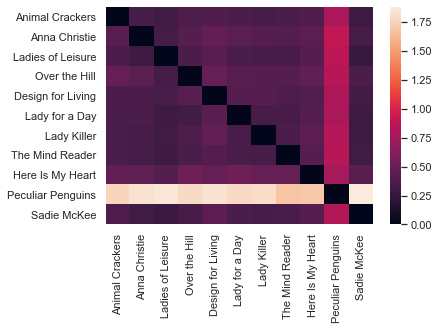

In [164]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/yslin624/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


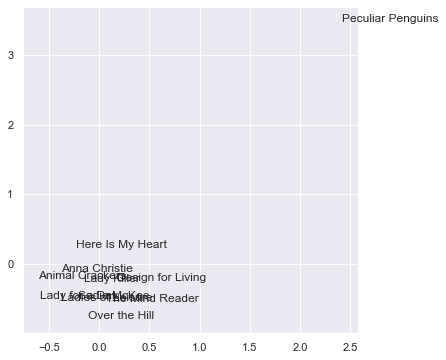

In [165]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

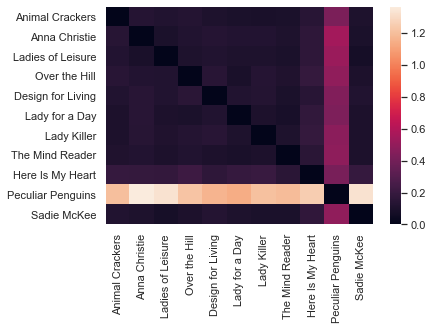

In [166]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

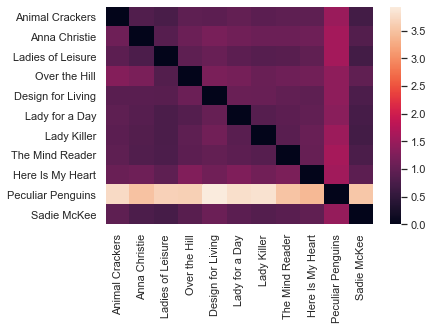

In [167]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

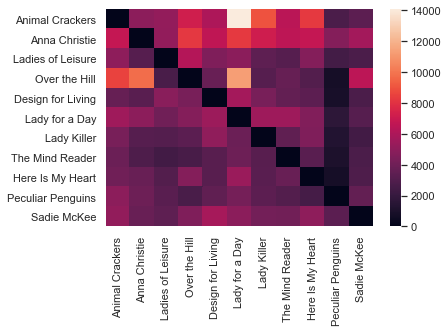

In [168]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

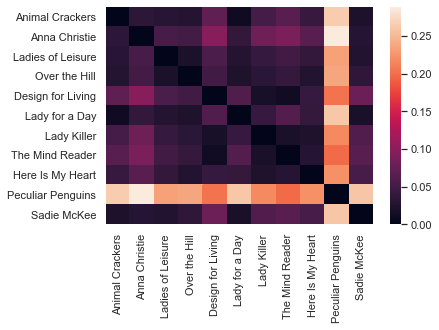

In [169]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

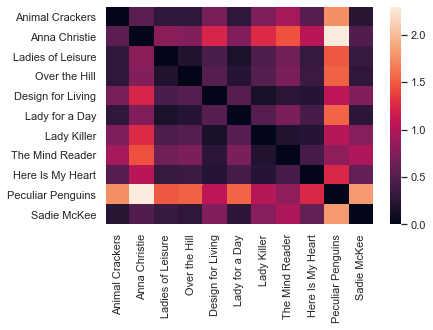

In [170]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

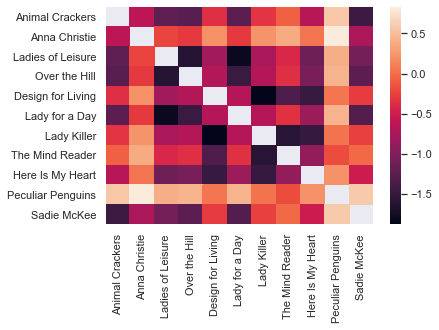

In [171]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [172]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [173]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

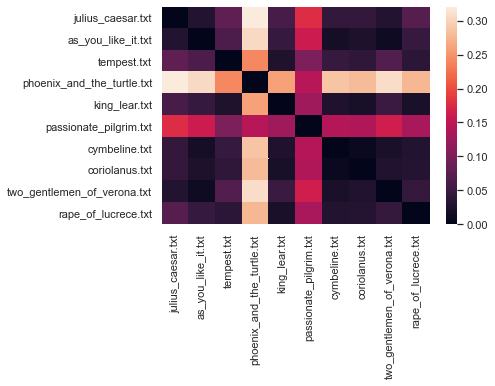

In [174]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [175]:
# I will probably get 4 different subset of corpus from 4 different txt file in COCA news section.
# Go up to the movie part, and get maybe 2011-2015 data out, sampling some of them, by genre if possible?
news_2015 = pandas.DataFrame({'text': clean_raw_text(coca_raw['2015_news.txt'][:200])})
news_2015['tokenized_text'] = news_2015['text'].apply(lambda x: word_tokenize(x))
news_2015['normalized_tokens'] = news_2015['tokenized_text'].apply(lambda x: normalizeTokens(x))


In [176]:
news_2014 = pandas.DataFrame({'text': clean_raw_text(coca_raw['2014_news.txt'][:200])})
news_2014['tokenized_text'] = news_2014['text'].apply(lambda x: word_tokenize(x))
news_2014['normalized_tokens'] = news_2014['tokenized_text'].apply(lambda x: normalizeTokens(x))


In [177]:
news_2013 = pandas.DataFrame({'text': clean_raw_text(coca_raw['2013_news.txt'][:200])})
news_2013['tokenized_text'] = news_2013['text'].apply(lambda x: word_tokenize(x))
news_2013['normalized_tokens'] = news_2013['tokenized_text'].apply(lambda x: normalizeTokens(x))


In [178]:
news_2012 = pandas.DataFrame({'text': clean_raw_text(coca_raw['2012_news.txt'][:200])})
news_2012['tokenized_text'] = news_2012['text'].apply(lambda x: word_tokenize(x))
news_2012['normalized_tokens'] = news_2012['tokenized_text'].apply(lambda x: normalizeTokens(x))


#### I plan to get 4 different years data, and then group them by different words.
#### For example, "president" would be thrown into politics and "block" would be social news. This is a very inaccurate way to sort things, if I can get the news_source going in the future, that would be much more accurate.

In [179]:
block_list = ['block', 'blocks', 'blocking', 'blocked']

def word_existence_check(word, ls):
    true = word in ls
    return true

block_2015 = news_2015
block_2015['truth'] = block_2015['normalized_tokens'].apply(lambda x: word_existence_check("block", x))
block_2015 = block_2015[block_2015['truth'] == True]
block_2015 = block_2015.reset_index()

block_2014 = news_2014
block_2014['truth'] = block_2014['normalized_tokens'].apply(lambda x: word_existence_check("block", x))
block_2014 = block_2014[block_2014['truth'] == True]
block_2014 = block_2014.reset_index()

block_2013 = news_2013
block_2013['truth'] = block_2013['normalized_tokens'].apply(lambda x: word_existence_check("block", x))
block_2013 = block_2013[block_2013['truth'] == True]
block_2013 = block_2013.reset_index()

block_2012 = news_2012
block_2012['truth'] = block_2012['normalized_tokens'].apply(lambda x: word_existence_check("block", x))
block_2012 = block_2012[block_2012['truth'] == True]
block_2012 = block_2012.reset_index()

In [180]:
politic_2015 = news_2015
politic_2015['truth'] = politic_2015['normalized_tokens'].apply(lambda x: word_existence_check("president", x))
politic_2015 = politic_2015[politic_2015['truth'] == True]
politic_2015 = politic_2015.reset_index()

politic_2014 = news_2014
politic_2014['truth'] = politic_2014['normalized_tokens'].apply(lambda x: word_existence_check("president", x))
politic_2014 = politic_2014[politic_2014['truth'] == True]
politic_2014 = politic_2014.reset_index()

politic_2013 = news_2013
politic_2013['truth'] = politic_2013['normalized_tokens'].apply(lambda x: word_existence_check("president", x))
politic_2013 = politic_2013[politic_2013['truth'] == True]
politic_2013 = politic_2013.reset_index()

politic_2012 = news_2012
politic_2012['truth'] = politic_2012['normalized_tokens'].apply(lambda x: word_existence_check("president", x))
politic_2012 = politic_2012[politic_2012['truth'] == True]
politic_2012 = politic_2012.reset_index()

In [181]:
# Calculate the divergence for 2015 case and see how similar they are

polWords = set(politic_2015['normalized_tokens'].sum())
blockWords = set(block_2015['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = polWords & blockWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

polProbArray = makeProbsArray(politic_2015['normalized_tokens'], overlapWordsDict)
blockProbArray = makeProbsArray(block_2015['normalized_tokens'], overlapWordsDict)

pol_blockDivergence = scipy.stats.entropy(polProbArray, blockProbArray)
print (pol_blockDivergence)
block_polDivergence = scipy.stats.entropy(blockProbArray, polProbArray)
print (block_polDivergence)

# Comparing to the kennedy and whitehouse release, this is really not that 

0.27212991044635165
0.39604787413016657


In [182]:
block_2015

,index,text,tokenized_text,normalized_tokens,truth
0,9,@@4132207 BP Chief Executive Bob Dudley has en...,"[@@4132207, BP, Chief, Executive, Bob, Dudley,...","[@@4132207, bp, chief, executive, bob, dudley,...",True
1,11,@@4132209 Republicans taking control of Congre...,"[@@4132209, Republicans, taking, control, of, ...","[@@4132209, republican, take, control, congres...",True
2,12,@@4132210 Burger joint Shake Shack filed for a...,"[@@4132210, Burger, joint, Shake, Shack, filed...","[@@4132210, burger, joint, shake, shack, file,...",True
3,18,@@4132216 In the galleries : Nature scenes wit...,"[@@4132216, In, the, galleries, Nature, scenes...","[@@4132216, gallery, nature, scene, religious,...",True
4,52,@@4132252 Outgoing Attorney General Eric Holde...,"[@@4132252, Outgoing, Attorney, General, Eric,...","[@@4132252, outgoing, attorney, general, eric,...",True
5,55,@@4132258 Two weeks after the White House was ...,"[@@4132258, Two, weeks, after, the, White, Hou...","[@@4132258, week, white, house, blindside, isr...",True
6,59,@@4132262 Alexandria and Arlington crime repor...,"[@@4132262, Alexandria, and, Arlington, crime,...","[@@4132262, alexandria, arlington, crime, repo...",True
7,61,@@4132264 House Speaker John A. Boehner surren...,"[@@4132264, House, Speaker, John, A., Boehner,...","[@@4132264, house, speaker, john, a., boehner,...",True
8,62,@@4132265 In a rousing speech before Congress ...,"[@@4132265, In, a, rousing, speech, before, Co...","[@@4132265, rousing, speech, congress, punctua...",True
9,70,"@@4132274 LAGOS , Nigeria - It was once a plac...","[@@4132274, LAGOS, Nigeria, It, was, once, a, ...","[@@4132274, lagos, nigeria, place, middle, cla...",True


In [183]:
c_list = [block_2015, block_2014, block_2013, block_2012, politic_2015, politic_2014, politic_2013, politic_2012]
name_list = ['block_2015', 'block_2014', 'block_2013', 'block_2012', 
             'politic_2015', 'politic_2014', 'politic_2013', 'politic_2012']
corpora = []

for corp in c_list:
    temp = []
    for text in corp['normalized_tokens']:
        for token in text:
            temp.append(token)
            
    corpora.append(temp)
    
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

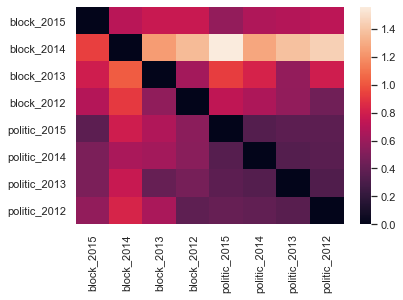

In [184]:
# The KL heatmap for the whole corpora

L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

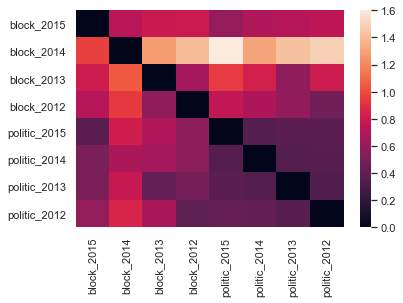

In [185]:
# The following 2 blocks are KL for stopword and nonstopword version
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

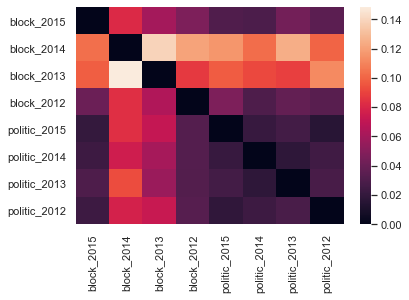

In [186]:
# The stop word version of this heatmap seems to be "very distinct"
# Probably should stick with nons for further analysis
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

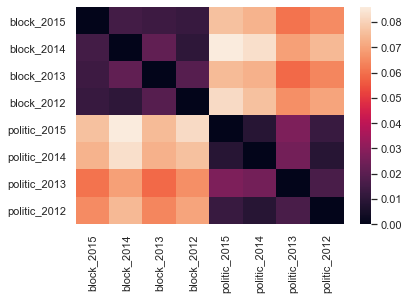

In [187]:
# KS distance
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference = 'KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

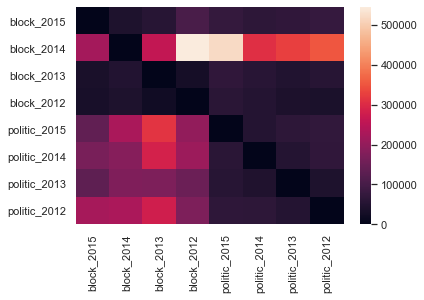

In [188]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference = 'Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

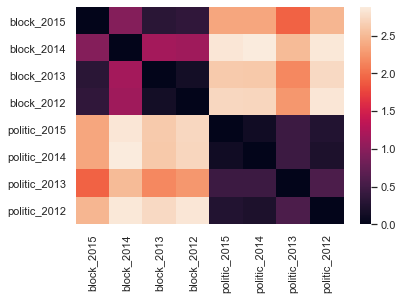

In [189]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference = 'Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = name_list, index = name_list)
ax = sns.heatmap(div)
plt.show()

### The result above, if the tech is correct, makes a bit sense, since KS and Wasserstein should produce similar result, and Chi2 and KL should be a pair. The information "shock" for 2014 block is a bit different, thus probably worth looking into, could it be difference in the social news reporting? Or are there other sampling problem that resulted in this divergence in result. 

### Another intersting thing is, it seems like news reporter have a better adherence to genre than to a specific year (which makes perfect sense, as most do reporting in specific categories instead of running around doing every category.) Also the politics field seems more concentrated in word usage, as "block" seems to be a bit more diverse, if we define concentration and divergence by their KS or Wasserstein divergence.